In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
from scripts.utils import set_all_seeds
from scripts.reinforce import run_validation

base_model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"
reward_model_id = "flypew/reward_model"
finetuned_model_id = "flypew/rlhf_model"

set_all_seeds(42)

In [21]:
dataset = load_dataset("esfrankel17/HelpSteer2_binarized")['average_rating_split'].train_test_split(test_size=100)
val_dataset = dataset['test']

In [22]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)

In [23]:
# Проверка что сид корректный чтобы подвыборка валидации была ровно та же что при обучении
assert val_dataset[0]['prompt'].startswith('wanglifan')

In [ ]:
device = "cuda"

tokenizer = AutoTokenizer.from_pretrained(base_model_id, padding_side="left")

model = AutoModelForCausalLM.from_pretrained(finetuned_model_id).to(device)
model.eval()

ref_model = AutoModelForCausalLM.from_pretrained(base_model_id).to(device)
ref_model.eval()

reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id).to(device)
reward_model.eval()

In [25]:
finetuned_rewards = run_validation(
    val_loader=val_loader,
    model=model,
    ref_model=ref_model,
    reward_model=reward_model,
    tokenizer=tokenizer,
    device=device,
    wandb_log=False,
    episode=None
)

Validation: 100%|██████████| 50/50 [04:20<00:00,  5.20s/it]

Validation - Avg. Reward: 0.3711, Avg. KL: 2.7197


In [26]:
baseline_rewards = run_validation(
    val_loader=val_loader,
    model=ref_model,
    ref_model=ref_model,
    reward_model=reward_model,
    tokenizer=tokenizer,
    device=device,
    wandb_log=False,
    episode=None
)

Validation: 100%|██████████| 50/50 [04:01<00:00,  4.82s/it]

Validation - Avg. Reward: 0.0499, Avg. KL: 0.0000


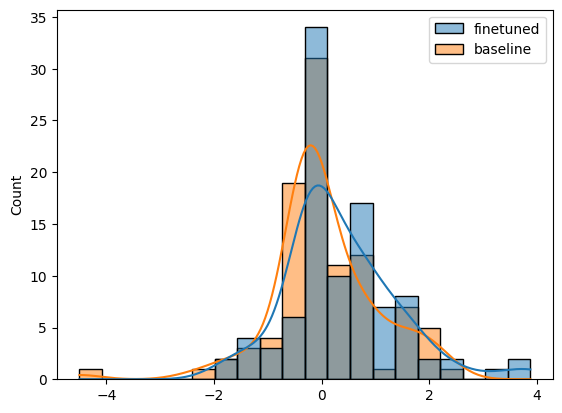

In [29]:
import seaborn as sns

import pandas as pd
data = pd.DataFrame({'finetuned': finetuned_rewards, 'baseline': baseline_rewards})

sns.histplot(data, bins=20, kde=True);

Средняя награда на валидации все таки выросла, но не так сильно как хотелось бы. Проверим более строго:

In [47]:
from scipy import stats
import numpy as np

diff = np.array(finetuned_rewards) - np.array(baseline_rewards)
_, p_value = stats.ttest_1samp(diff, 0, alternative='greater')
p_value.item()

0.008264372998962705